In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
from models import VGG16

import os
from tqdm import tqdm

/jun/anaconda3/envs/visual_ai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vgg16 = VGG16(num_classes=88, use_pretrain=True)

/jun/anaconda3/envs/visual_ai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/jun/anaconda3/envs/visual_ai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# 데이터셋 경로 설정
dataset_train_path = os.path.join("mvtec_anomaly_detection_imagefolder", "train")
dataset_validation_path = os.path.join("mvtec_anomaly_detection_imagefolder", "validation")

# 이미지 변환 설정
transform = transforms.Compose([transforms.Resize((112, 112)),
                                transforms.ToTensor(),
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 데이터셋의 평균과 표준편차 사용
                                ])

# 데이터셋 로드
train_dataset = torchvision.datasets.ImageFolder(root=dataset_train_path, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root=dataset_validation_path, transform=transform)

# 데이터 로더 설정
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# VGG16 모델 불러오기
# vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16 = VGG16(num_classes=88, use_pretrain=True)

# GPU를 사용할 수 있는 경우 GPU로 모델을 이동합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

# 손실 함수 및 최적화기 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)


In [7]:
train_dataset.classes

['bottle-broken_large',
 'bottle-broken_small',
 'bottle-contamination',
 'bottle-good',
 'cable-bent_wire',
 'cable-cable_swap',
 'cable-combined',
 'cable-cut_inner_insulation',
 'cable-cut_outer_insulation',
 'cable-good',
 'cable-missing_cable',
 'cable-missing_wire',
 'cable-poke_insulation',
 'capsule-crack',
 'capsule-faulty_imprint',
 'capsule-good',
 'capsule-poke',
 'capsule-scratch',
 'capsule-squeeze',
 'carpet-color',
 'carpet-cut',
 'carpet-good',
 'carpet-hole',
 'carpet-metal_contamination',
 'carpet-thread',
 'grid-bent',
 'grid-broken',
 'grid-glue',
 'grid-good',
 'grid-metal_contamination',
 'grid-thread',
 'hazelnut-crack',
 'hazelnut-cut',
 'hazelnut-good',
 'hazelnut-hole',
 'hazelnut-print',
 'leather-color',
 'leather-cut',
 'leather-fold',
 'leather-glue',
 'leather-good',
 'leather-poke',
 'metal_nut-bent',
 'metal_nut-color',
 'metal_nut-flip',
 'metal_nut-good',
 'metal_nut-scratch',
 'pill-color',
 'pill-combined',
 'pill-contamination',
 'pill-crack',
 'p

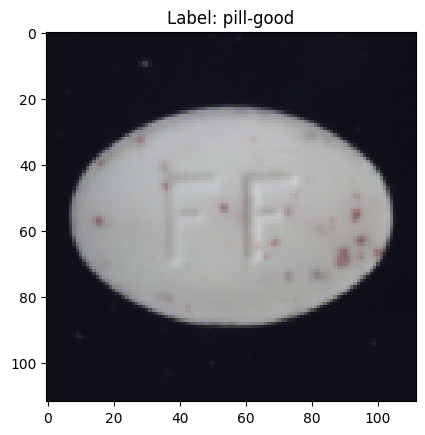

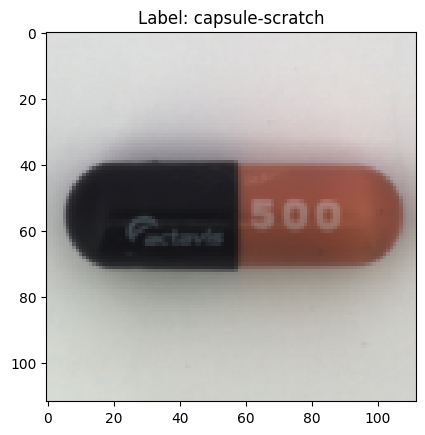

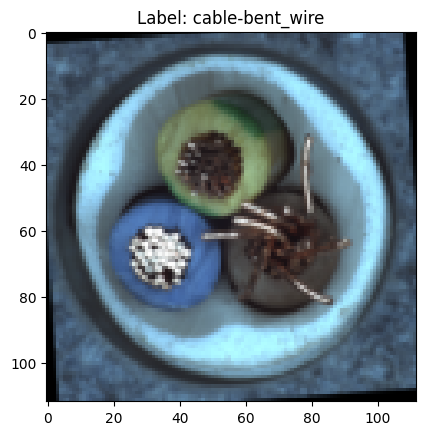

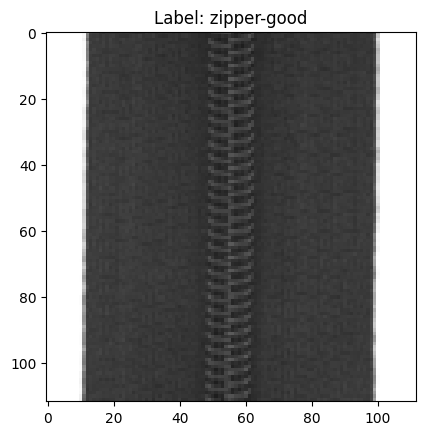

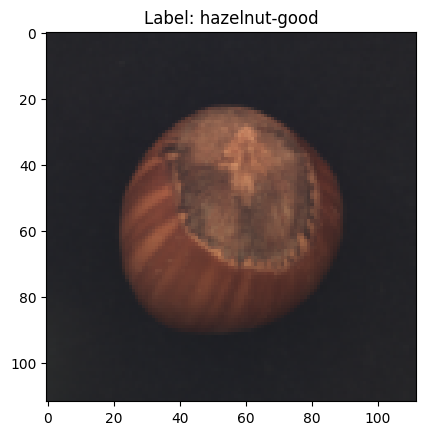

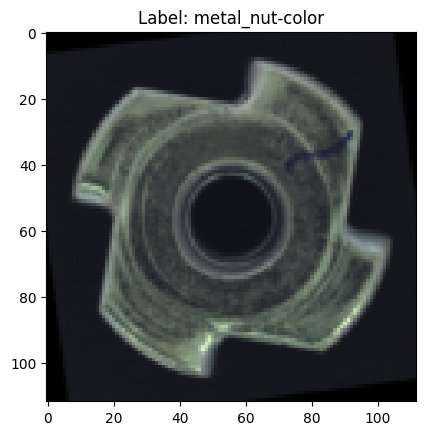

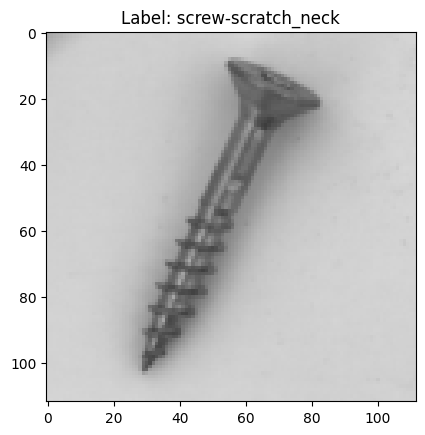

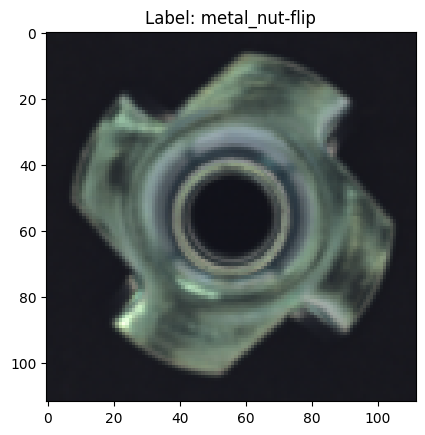

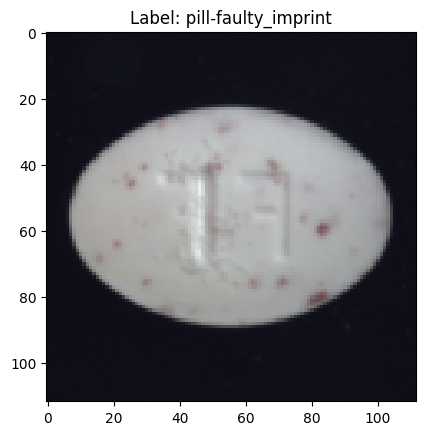

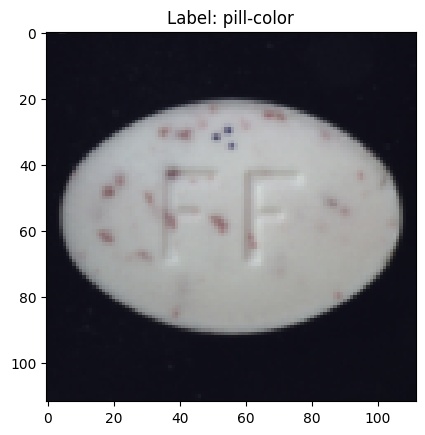

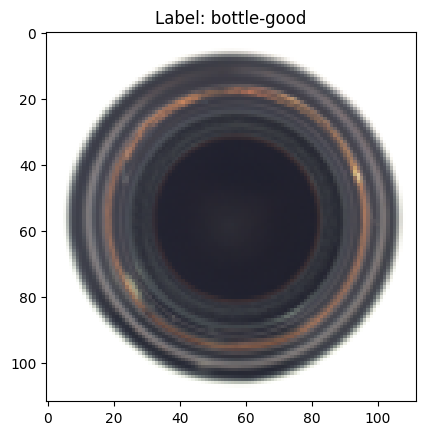

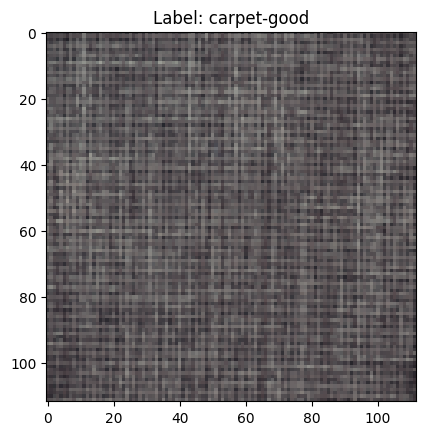

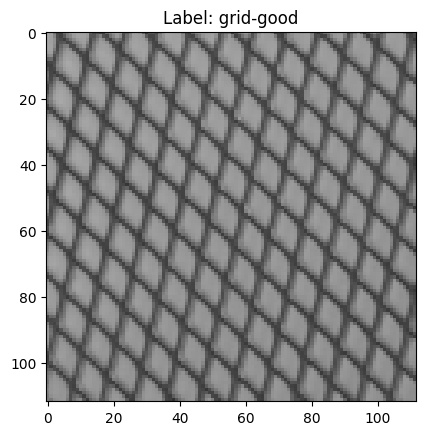

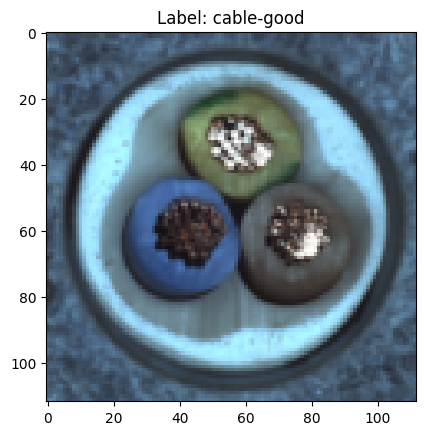

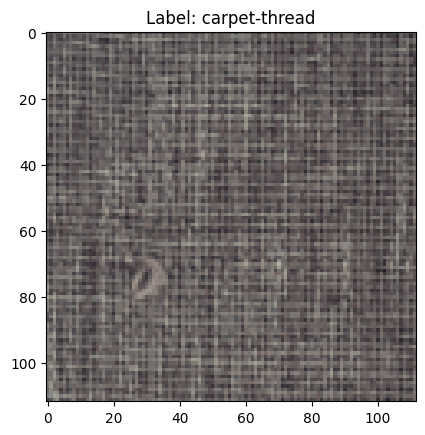

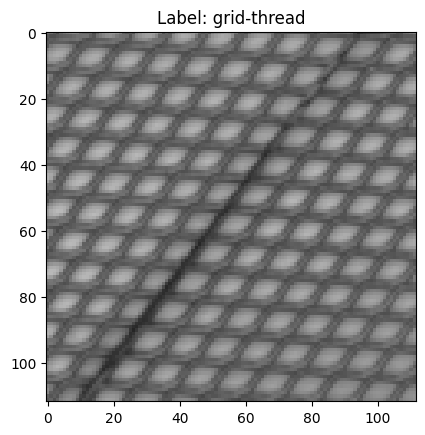

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 로더에서 한 배치만 가져옵니다.
images, labels = next(iter(train_loader))
# class_name_list = os.listdir(os.path.join("mvtec_anomaly_detection_imagefolder", "train"))
class_name_list = train_dataset.classes

# 이미지와 레이블 확인
for i in range(batch_size):
    image = images[i]  # 이미지
    label = labels[i].item()  # 레이블

    # 이미지를 시각화합니다.
    image = image.numpy().transpose((1, 2, 0))  # 이미지 차원을 (C, H, W)에서 (H, W, C)로 변경
    image = np.clip(image, 0, 1)  # 픽셀 값 범위를 [0, 1]로 조정
    plt.imshow(image)
    plt.title(f"Label: {class_name_list[label]}")
    plt.show()


In [9]:
import os

# 모델 저장 경로 설정
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
best_model_path = os.path.join(checkpoint_dir, "best_model.pth")

# 학습 함수 정의
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_accuracy = 0.0  # 가장 높은 검증 정확도 초기화
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            # 각 미니배치의 손실 및 정확도 표시
            train_loss = running_loss / total_train
            train_accuracy = correct_train / total_train
            pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        
        # 검증 데이터로 정확도 측정
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_pbar = tqdm(enumerate(val_loader), total=len(val_loader))  # 검증 데이터에 대한 tqdm 설정
        with torch.no_grad():
            for j, (inputs, labels) in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
                # 검증 데이터의 손실 및 정확도 표시
                val_loss_avg = val_loss / total_val
                val_accuracy = correct_val / total_val
                val_pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss_avg:.4f}, Val Acc: {val_accuracy:.4f}")
        
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct_val / total_val
        
        # 손실과 정확도 기록
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # 가장 높은 검증 정확도를 가진 모델을 저장
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at: {best_model_path}")
    
    # 학습 결과 반환
    return train_losses, val_losses, train_accuracies, val_accuracies


In [10]:
# 학습 실행
train_losses, val_losses, train_accuracies, val_accuracies = train_model(vgg16, criterion, optimizer, train_loader, val_loader, num_epochs=10)

Epoch [1/10], Train Loss: 2.4310, Train Acc: 0.4440: 100%|██████████| 328/328 [03:05<00:00,  1.77it/s]
Epoch [1/10], Val Loss: 1.5694, Val Acc: 0.5589: 100%|██████████| 57/57 [00:29<00:00,  1.95it/s]


Epoch [1/10], Train Loss: 2.4310, Val Loss: 1.5694, Train Acc: 0.4440, Val Acc: 0.5589
Best model saved at: checkpoints/best_model.pth


Epoch [2/10], Train Loss: 1.5307, Train Acc: 0.5241: 100%|██████████| 328/328 [03:01<00:00,  1.80it/s]
Epoch [2/10], Val Loss: 1.3807, Val Acc: 0.5422: 100%|██████████| 57/57 [00:29<00:00,  1.95it/s]


Epoch [2/10], Train Loss: 1.5307, Val Loss: 1.3807, Train Acc: 0.5241, Val Acc: 0.5422


Epoch [3/10], Train Loss: 1.3516, Train Acc: 0.5640: 100%|██████████| 328/328 [02:59<00:00,  1.83it/s]
Epoch [3/10], Val Loss: 1.1911, Val Acc: 0.6078: 100%|██████████| 57/57 [00:28<00:00,  2.00it/s]


Epoch [3/10], Train Loss: 1.3516, Val Loss: 1.1911, Train Acc: 0.5640, Val Acc: 0.6078
Best model saved at: checkpoints/best_model.pth


Epoch [4/10], Train Loss: 1.2160, Train Acc: 0.5966: 100%|██████████| 328/328 [02:58<00:00,  1.84it/s]
Epoch [4/10], Val Loss: 1.1553, Val Acc: 0.5989: 100%|██████████| 57/57 [00:28<00:00,  2.00it/s]


Epoch [4/10], Train Loss: 1.2160, Val Loss: 1.1553, Train Acc: 0.5966, Val Acc: 0.5989


Epoch [5/10], Train Loss: 1.1597, Train Acc: 0.6205: 100%|██████████| 328/328 [02:56<00:00,  1.86it/s]
Epoch [5/10], Val Loss: 1.1388, Val Acc: 0.6311: 100%|██████████| 57/57 [00:28<00:00,  1.99it/s]


Epoch [5/10], Train Loss: 1.1597, Val Loss: 1.1388, Train Acc: 0.6205, Val Acc: 0.6311
Best model saved at: checkpoints/best_model.pth


Epoch [6/10], Train Loss: 1.0979, Train Acc: 0.6434: 100%|██████████| 328/328 [02:57<00:00,  1.84it/s]
Epoch [6/10], Val Loss: 1.0512, Val Acc: 0.6533: 100%|██████████| 57/57 [00:28<00:00,  1.98it/s]


Epoch [6/10], Train Loss: 1.0979, Val Loss: 1.0512, Train Acc: 0.6434, Val Acc: 0.6533
Best model saved at: checkpoints/best_model.pth


Epoch [7/10], Train Loss: 1.0285, Train Acc: 0.6541: 100%|██████████| 328/328 [02:57<00:00,  1.85it/s]
Epoch [7/10], Val Loss: 0.9545, Val Acc: 0.6644: 100%|██████████| 57/57 [00:27<00:00,  2.09it/s]


Epoch [7/10], Train Loss: 1.0285, Val Loss: 0.9545, Train Acc: 0.6541, Val Acc: 0.6644
Best model saved at: checkpoints/best_model.pth


Epoch [8/10], Train Loss: 0.9697, Train Acc: 0.6802: 100%|██████████| 328/328 [02:48<00:00,  1.94it/s]
Epoch [8/10], Val Loss: 0.9708, Val Acc: 0.6433: 100%|██████████| 57/57 [00:27<00:00,  2.09it/s]


Epoch [8/10], Train Loss: 0.9697, Val Loss: 0.9708, Train Acc: 0.6802, Val Acc: 0.6433


Epoch [9/10], Train Loss: 0.9417, Train Acc: 0.6848: 100%|██████████| 328/328 [02:48<00:00,  1.94it/s]
Epoch [9/10], Val Loss: 0.9532, Val Acc: 0.6678: 100%|██████████| 57/57 [00:27<00:00,  2.09it/s]


Epoch [9/10], Train Loss: 0.9417, Val Loss: 0.9532, Train Acc: 0.6848, Val Acc: 0.6678
Best model saved at: checkpoints/best_model.pth


Epoch [10/10], Train Loss: 0.9129, Train Acc: 0.6930: 100%|██████████| 328/328 [02:49<00:00,  1.94it/s]
Epoch [10/10], Val Loss: 0.9178, Val Acc: 0.6911: 100%|██████████| 57/57 [00:27<00:00,  2.08it/s]


Epoch [10/10], Train Loss: 0.9129, Val Loss: 0.9178, Train Acc: 0.6930, Val Acc: 0.6911
Best model saved at: checkpoints/best_model.pth


## Training Results

In [11]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracies(train_accuracies, val_accuracies):
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

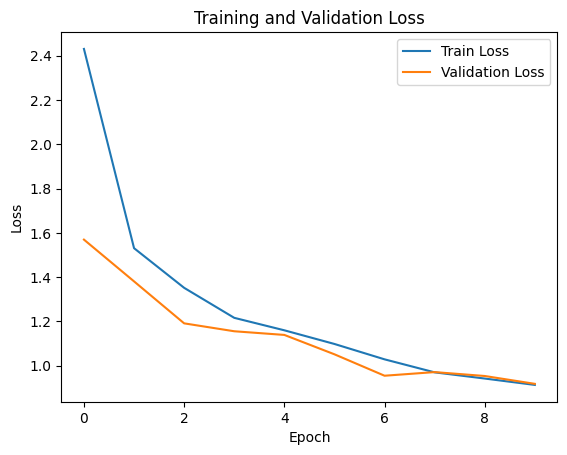

In [12]:
plot_losses(train_losses, val_losses)

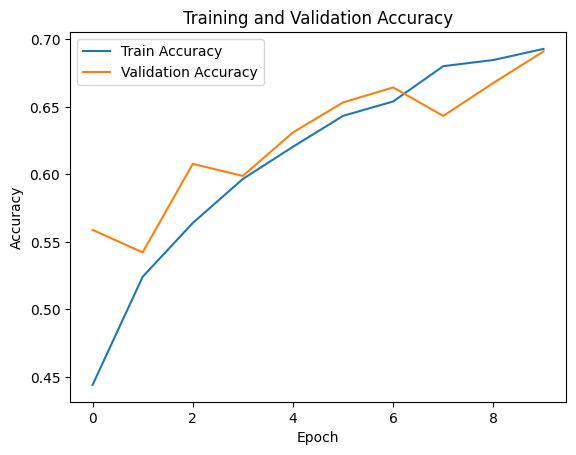

In [13]:
plot_accuracies(train_accuracies, val_accuracies)